<a href="https://colab.research.google.com/github/nicklausmillican/StatisticalRethinkingIISolutions/blob/main/ModelingSleep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
install.packages(c("coda","mvtnorm","devtools","loo","dagitty"))
devtools::install_github("rmcelreath/rethinking@slim")

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘httpuv’, ‘xtable’, ‘sourcetools’, ‘later’, ‘promises’, ‘shiny’, ‘downlit’, ‘htmlwidgets’, ‘Rcpp’, ‘miniUI’, ‘pkgdown’, ‘profvis’, ‘urlchecker’, ‘checkmate’, ‘matrixStats’, ‘V8’





shape (NA -> 1.4.6) [CRAN]


Installing 1 packages: shape

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpA3H16h/remotesee38444722/rmcelreath-rethinking-cbcb8ba/DESCRIPTION’ ... OK
* preparing ‘rethinking’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* looking to see if a ‘data/datalist’ file should be added
* building ‘rethinking_2.13.2.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(rethinking)

Loading required package: parallel

rethinking (Version 2.13.2)


Attaching package: ‘rethinking’


The following object is masked from ‘package:stats’:

    rstudent




# Introduction
Here, we'll build a model of sleep in rodents.  We'll start with a basic model, that uses some assumptions that are less than ideal, then iterate on the model with some complexities that should make it a better model for sleep.  

First, some important facts about sleep and sleep in rodents:
*   In a lab envrionment, rodents usually live in a light-controlled environment; the lights on are for 12 consecutive hours and then off for 12 consecutive hours.  Thus, each 24-h day consists of a *Light* phase and a *Dark* phase.
*   There are 2 basic vigilance states, WAKE and SLEEP.  Within SLEEP, there are 2 basic types, rapid-eye-movement sleep (REMS) and non-REMS (NREMS).  NREMS usually makes up about 80-90% of sleep, while REMS makes up the remainder.
*   Sleep is a rhythmic behavior.  Over the course of a day, rodents exhibit both WAKE and SLEEP, including NREMS and REMS, throughout the entire day.  However, they are **nocturnal**, which means that most of their sleep occurs during the Light phase.  Within each 12-h phase, smaller rhythms are present.  For instance, the propensity for SLEEP may rise and fall over 3-h and 6-h periods.
*  REMS is usually all but absent in the beginning of a 12-h phase, but becomes more prevalent towards the end.

## The Data
Before we can model, we need to create some data.  We'll imagine 2 groups of rats: one group received an injection of a substance *S* that we think may affect sleep, and the other group only received a placebo injection  (Later, instead of groups, we'll imagine that each rat is treated with both placebo and substance S).

DISCLAIMER: Sleep is a very complex and architectured process.  The data created here will only account for some basic features of that complex architecture.  

In [ ]:
n_A <- 10 # Number of rats in Group A
n_B <- 10 # Number of rats in Group B

NREMS_A <- data.frame(#"Blk0" = rep(0, n_A),
                      "Blk1" = rgamma(n = n_A, shape=144, rate=2.4) * (1/21), # 1h NREMS in 0-6h
                      "Blk2" = rgamma(n = n_A, shape=144, rate=2.4) * (2/21),
                      "Blk3" = rgamma(n = n_A, shape=144, rate=2.4) * (3/21),
                      "Blk4" = rgamma(n = n_A, shape=144, rate=2.4) * (4/21),
                      "Blk5" = rgamma(n = n_A, shape=144, rate=2.4) * (5/21),
                      "Blk6" = rgamma(n = n_A, shape=144, rate=2.4) * (6/21),

                      "Blk7" = rgamma(n=n_A, shape=576, rate=4.8) * (1/21), # 2h NREMS in 6-12h
                      "Blk8" = rgamma(n=n_A, shape=576, rate=4.8) * (2/21),
                      "Blk9" = rgamma(n=n_A, shape=576, rate=4.8) * (3/21),
                      "Blk10" = rgamma(n=n_A, shape=576, rate=4.8) * (4/21),
                      "Blk11" = rgamma(n=n_A, shape=576, rate=4.8) * (5/21),
                      "Blk12" = rgamma(n=n_A, shape=576, rate=4.8) * (6/21),

                      "Blk13" = rgamma(n=n_A, shape=1296, rate=7.2) * 6/21, # 3h NREMS in 12-18h
                      "Blk14" = rgamma(n=n_A, shape=1296, rate=7.2) * 5/21,
                      "Blk15" = rgamma(n=n_A, shape=1296, rate=7.2) * 4/21,
                      "Blk16" = rgamma(n=n_A, shape=1296, rate=7.2) * 3/21,
                      "Blk17" = rgamma(n=n_A, shape=1296, rate=7.2) * 2/21,
                      "Blk18" = rgamma(n=n_A, shape=1296, rate=7.2) * 1/21,

                      "Blk19" = rgamma(n=n_A, shape=900, rate=6.0) * (6/21), # 2.5h NREMS in 18-24h
                      "Blk20" = rgamma(n=n_A, shape=900, rate=6.0) * (5/21),
                      "Blk21" = rgamma(n=n_A, shape=900, rate=6.0) * (4/21),
                      "Blk22" = rgamma(n=n_A, shape=900, rate=6.0) * (3/21),
                      "Blk23" = rgamma(n=n_A, shape=900, rate=6.0) * (2/21),
                      "Blk24" = rgamma(n=n_A, shape=900, rate=6.0) * (1/21))

REMS_A <- data.frame("Blk1" = (60 - NREMS_A$Blk1)*.01,
                     "Blk2" = (60 - NREMS_A$Blk1)*.01,
                     "Blk3" = (60 - NREMS_A$Blk1)*.01,
                     "Blk4" = (60 - NREMS_A$Blk1)*.01,
                     "Blk5" = (60 - NREMS_A$Blk1)*.01,
                     "Blk6" = (60 - NREMS_A$Blk1)*.01,

                     "Blk7" = (60 - NREMS_A$Blk1)*.05,
                     "Blk8" = (60 - NREMS_A$Blk1)*.05,
                     "Blk9" = (60 - NREMS_A$Blk1)*.05,
                     "Blk10" = (60 - NREMS_A$Blk1)*.05,
                     "Blk11" = (60 - NREMS_A$Blk1)*.05,
                     "Blk12" = (60 - NREMS_A$Blk1)*.05,

                     "Blk13" = (60 - NREMS_A$Blk1)*.05,
                     "Blk14" = (60 - NREMS_A$Blk1)*.05,
                     "Blk15" = (60 - NREMS_A$Blk1)*.05,
                     "Blk16" = (60 - NREMS_A$Blk1)*.05,
                     "Blk17" = (60 - NREMS_A$Blk1)*.05,
                     "Blk18" = (60 - NREMS_A$Blk1)*.05,

                     "Blk19" = (60 - NREMS_A$Blk1)*.1,
                     "Blk20" = (60 - NREMS_A$Blk1)*.1,
                     "Blk21" = (60 - NREMS_A$Blk1)*.1,
                     "Blk22" = (60 - NREMS_A$Blk1)*.1,
                     "Blk23" = (60 - NREMS_A$Blk1)*.1,
                     "Blk24" = (60 - NREMS_A$Blk1)*.1)


NREMS_B <- data.frame(#"Blk0" = rep(0, n_B),
                      "Blk1" = (rgamma(n = n_B, shape=144, rate=2.4) + rnorm(n=n_B, mean=30, sd=6)) * (1/21), # Similar to NREMS_A, but with the effect of S added
                      "Blk2" = (rgamma(n = n_B, shape=144, rate=2.4) + rnorm(n=n_B, mean=30, sd=6)) * (2/21),
                      "Blk3" = (rgamma(n = n_B, shape=144, rate=2.4) + rnorm(n=n_B, mean=30, sd=6)) * (3/21),
                      "Blk4" = (rgamma(n = n_B, shape=144, rate=2.4) + rnorm(n=n_B, mean=30, sd=6)) * (4/21),
                      "Blk5" = (rgamma(n = n_B, shape=144, rate=2.4) + rnorm(n=n_B, mean=30, sd=6)) * (5/21),
                      "Blk6" = (rgamma(n = n_B, shape=144, rate=2.4) + rnorm(n=n_B, mean=30, sd=6)) * (6/21),

                      "Blk7" = (rgamma(n=n_B, shape=576, rate=4.8) + rnorm(n=n_B, mean=20, sd=5)) * (1/21),
                      "Blk8" = (rgamma(n=n_B, shape=576, rate=4.8) + rnorm(n=n_B, mean=20, sd=5)) * (2/21),
                      "Blk9" = (rgamma(n=n_B, shape=576, rate=4.8) + rnorm(n=n_B, mean=20, sd=5)) * (3/21),
                      "Blk10" = (rgamma(n=n_B, shape=576, rate=4.8) + rnorm(n=n_B, mean=20, sd=5)) * (4/21),
                      "Blk11" = (rgamma(n=n_B, shape=576, rate=4.8) + rnorm(n=n_B, mean=20, sd=5)) * (5/21),
                      "Blk12" = (rgamma(n=n_B, shape=576, rate=4.8) + rnorm(n=n_B, mean=20, sd=5)) * (6/21),

                      "Blk13" = (rgamma(n=n_B, shape=1296, rate=7.2) + rnorm(n=n_B, mean=10, sd=4)) * (6/21),
                      "Blk14" = (rgamma(n=n_B, shape=1296, rate=7.2) + rnorm(n=n_B, mean=10, sd=4)) * (5/21),
                      "Blk15" = (rgamma(n=n_B, shape=1296, rate=7.2) + rnorm(n=n_B, mean=10, sd=4)) * (4/21),
                      "Blk16" = (rgamma(n=n_B, shape=1296, rate=7.2) + rnorm(n=n_B, mean=10, sd=4)) * (3/21),
                      "Blk17" = (rgamma(n=n_B, shape=1296, rate=7.2) + rnorm(n=n_B, mean=10, sd=4)) * (2/21),
                      "Blk18" = (rgamma(n=n_B, shape=1296, rate=7.2) + rnorm(n=n_B, mean=10, sd=4)) * (1/21),

                      "Blk19" = (rgamma(n=n_B, shape=900, rate=6.0) + rnorm(n=n_B, mean=5, sd=3)) * (6/21),
                      "Blk20" = (rgamma(n=n_B, shape=900, rate=6.0) + rnorm(n=n_B, mean=5, sd=3)) * (5/21),
                      "Blk21" = (rgamma(n=n_B, shape=900, rate=6.0) + rnorm(n=n_B, mean=5, sd=3)) * (4/21),
                      "Blk22" = (rgamma(n=n_B, shape=900, rate=6.0) + rnorm(n=n_B, mean=5, sd=3)) * (3/21),
                      "Blk23" = (rgamma(n=n_B, shape=900, rate=6.0) + rnorm(n=n_B, mean=5, sd=3)) * (2/21),
                      "Blk24" = (rgamma(n=n_B, shape=900, rate=6.0) + rnorm(n=n_B, mean=5, sd=3)) * (1/21))

REMS_B <- data.frame("Blk1" = (60 - NREMS_B$Blk1)*.01,
                     "Blk2" = (60 - NREMS_B$Blk1)*.01,
                     "Blk3" = (60 - NREMS_B$Blk1)*.01,
                     "Blk4" = (60 - NREMS_B$Blk1)*.01,
                     "Blk5" = (60 - NREMS_B$Blk1)*.01,
                     "Blk6" = (60 - NREMS_B$Blk1)*.01,

                     "Blk7" = (60 - NREMS_B$Blk1)*.05,
                     "Blk8" = (60 - NREMS_B$Blk1)*.05,
                     "Blk9" = (60 - NREMS_B$Blk1)*.05,
                     "Blk10" = (60 - NREMS_B$Blk1)*.05,
                     "Blk11" = (60 - NREMS_B$Blk1)*.05,
                     "Blk12" = (60 - NREMS_B$Blk1)*.05,

                     "Blk13" = (60 - NREMS_B$Blk1)*.05,
                     "Blk14" = (60 - NREMS_B$Blk1)*.05,
                     "Blk15" = (60 - NREMS_B$Blk1)*.05,
                     "Blk16" = (60 - NREMS_B$Blk1)*.05,
                     "Blk17" = (60 - NREMS_B$Blk1)*.05,
                     "Blk18" = (60 - NREMS_B$Blk1)*.05,

                     "Blk19" = (60 - NREMS_B$Blk1)*.1,
                     "Blk20" = (60 - NREMS_B$Blk1)*.1,
                     "Blk21" = (60 - NREMS_B$Blk1)*.1,
                     "Blk22" = (60 - NREMS_B$Blk1)*.1,
                     "Blk23" = (60 - NREMS_B$Blk1)*.1,
                     "Blk24" = (60 - NREMS_B$Blk1)*.1)

m_NREMS <- length(NREMS_A) # number of measurements for NREMS.
m_REMS <- length(REMS_A) # number of measurements for REMS.

So we have NREMS and REMS for both groups of rats for each of 24 consecutive hours.  In the first part of this project, we'll focus primarily on NREMS.

There's something weird with this type of data.  For each time block, the amount of NREMS represented in that data point has been accumulated over the preceeding time block.  So even though the data is discrete like this:

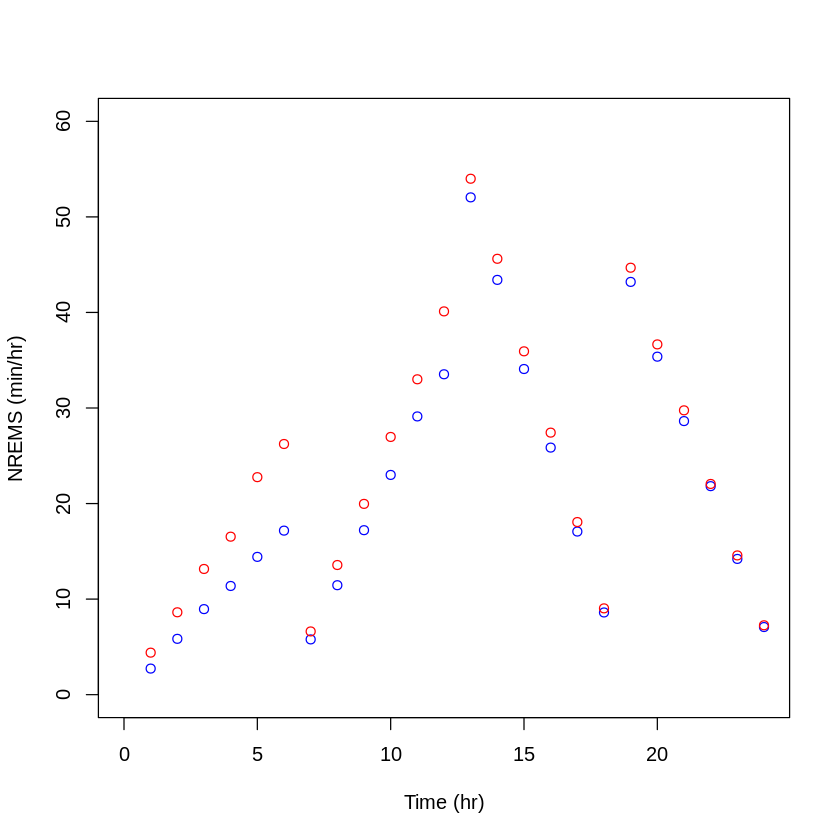

In [ ]:
plot(colMeans(NREMS_A), ylim=c(0,60), xlim=c(0,24), col="blue", xlab="Time (hr)", ylab="NREMS (min/hr)")
points(colMeans(NREMS_B), col="red")

It's often thought about and presented as a continuous function like this:

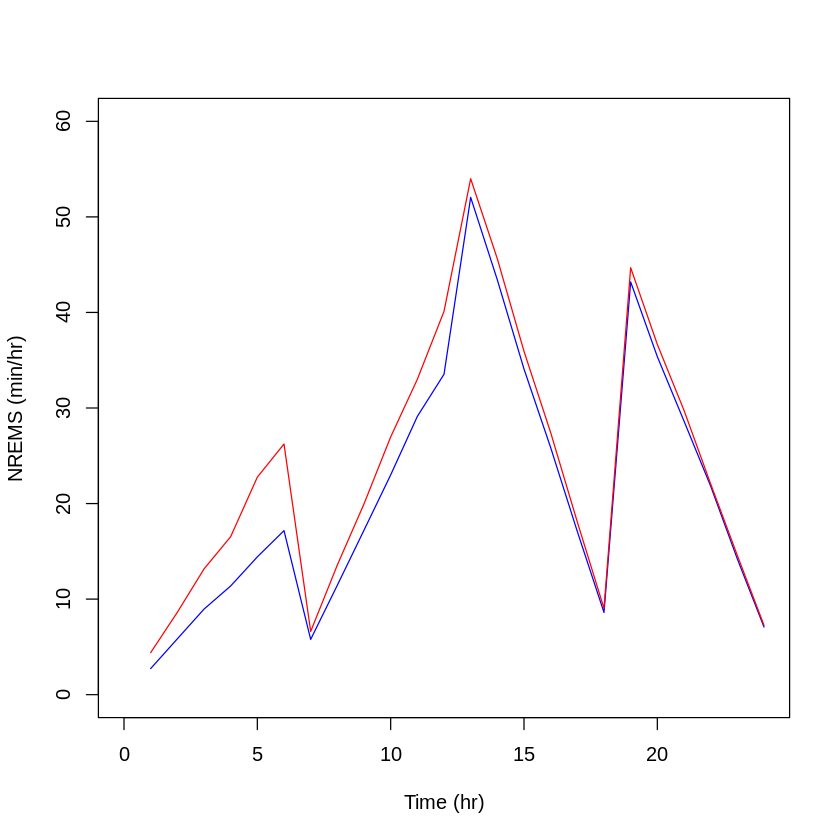

In [ ]:
plot(colMeans(NREMS_A), type="l", ylim=c(0,60), xlim=c(0,24), col="blue", xlab="Time (hr)", ylab="NREMS (min/hr)")
lines(colMeans(NREMS_B), col="red")

But in this case, we're forced to think about the y-axis value of a line as being something like "NREMS *propensity*".  Why? Take any 2 points along a curve, say 13 hr 0 min and 13 h 1 min; this representation would say that some 100 minutes of NREMS accumulated in 1 min...which is nonsensical.  So let's put this on a scale that fixes this, by working with accumulated NREMS.

In [ ]:
NREMS_A_cuml <- NREMS_A
for(i in 2:ncol(NREMS_A)) {
  NREMS_A_cuml[,i] <- NREMS_A_cuml[,i] + NREMS_A_cuml[,i-1]
}

REMS_A_cuml <- REMS_A
for(i in 2:ncol(REMS_A)) {
  REMS_A_cuml[,i] <- REMS_A_cuml[,i] + REMS_A_cuml[,i-1]
}

NREMS_B_cuml <- NREMS_B
for(i in 2:ncol(NREMS_B)) {
  NREMS_B_cuml[,i] <- NREMS_B_cuml[,i] + NREMS_B_cuml[,i-1]
}

REMS_B_cuml <- REMS_B
for(i in 2:ncol(REMS_B)) {
  REMS_B_cuml[,i] <- REMS_B_cuml[,i] + REMS_B_cuml[,i-1]
}

Now it makes sense to treat NREMS as a continuous function.

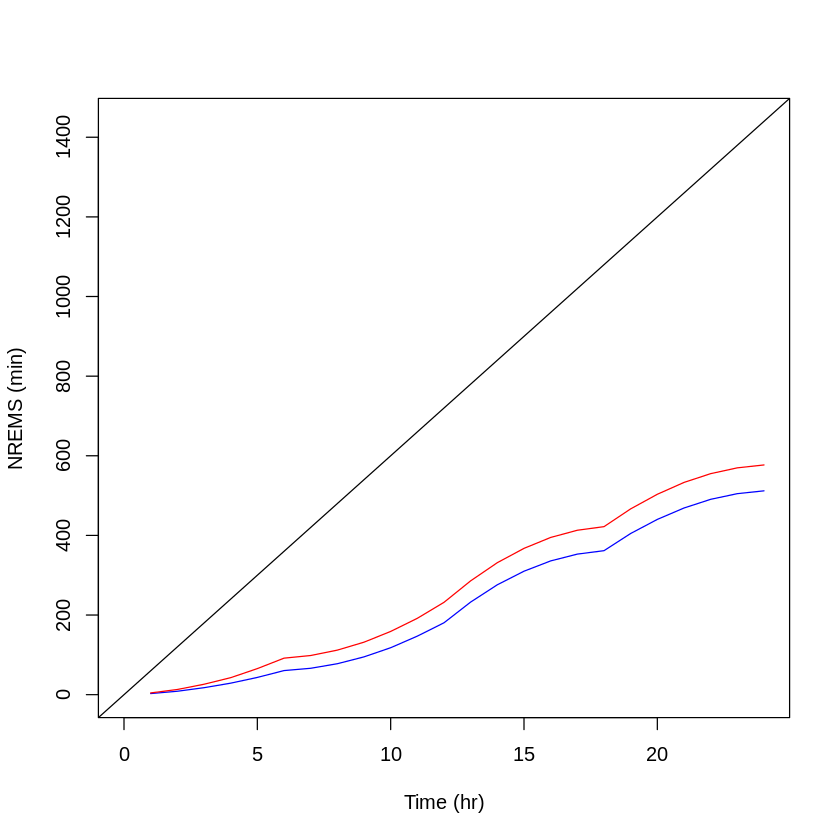

In [ ]:
plot(colMeans(NREMS_A_cuml), type="l", ylim=c(0,1440), xlim=c(0,24), col="blue", xlab="Time (hr)", ylab="NREMS (min)")
lines(colMeans(NREMS_B_cuml), col="red")
abline(a=0, b=1440/24)

(the black diagnol line represents the total time elapsed).

Now, the difference between any two timepoints *does* represent accumualted NREMS.

Now I'm just going to repackage the data into a convenient-to-use dataframe.

In [ ]:
TotalPreviousSleep_A <- as.numeric(unlist(cbind(0, NREMS_A_cuml[,1:23])) + unlist(cbind(0, REMS_A_cuml[,1:23])))
TotalPreviousSleep_B <- as.numeric(unlist(cbind(0, NREMS_B_cuml[,1:23])) + unlist(cbind(0, REMS_B_cuml[,1:23])))

Sleep_All <- data.frame("Subject" = rep(LETTERS[1:n_A], 2*m_NREMS),
                        "NREMS" = c(as.numeric(unlist(NREMS_A_cuml)), as.numeric(unlist(NREMS_B_cuml))),
                        "REMS" = c(as.numeric(unlist(REMS_A_cuml)), as.numeric(unlist(REMS_B_cuml))),
                        "TotalPreviousSleep" = c(TotalPreviousSleep_A, TotalPreviousSleep_B),
                        "Group" = c(rep("A", (m_NREMS)*n_A), c(rep("B", (m_NREMS)*n_B))),
                        "Block" = c(rep(1:24, each=n_A), c(rep(1:24, each=n_B))))

Sleep_All$treatment <- ifelse(test = Sleep_All$Group=="A",
                              yes = FALSE,
                              no = TRUE)
Sleep_All$minute <- Sleep_All$Block*60

head(Sleep_All)

,Subject,NREMS,REMS,TotalPreviousSleep,Group,Block,treatment,minute
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<lgl>,<dbl>
1,A,2.868949,0.5713105,0,A,1,FALSE,60
2,B,2.723094,0.5727691,0,A,1,FALSE,60
3,C,2.842684,0.5715732,0,A,1,FALSE,60
4,D,2.637590,0.5736241,0,A,1,FALSE,60
5,E,2.568381,0.5743162,0,A,1,FALSE,60
6,F,2.570593,0.5742941,0,A,1,FALSE,60


# Model 1
We'll start by modeling only NREMS.  We'll assume that NREMS is normally distributed.  This is not a great assumption, and we'll change it in later iterations, but it'll help get us started.

Since NREMS follows a type of continuous rhythm throughout the day, we'll first use splines to model it.

In [ ]:
knot_list <- c(360, 720, 1080)
num_knots <- length(knot_list)
knot_degree <- 3

 'bs' num [1:24, 1:7] 1 0.512 0.216 0.064 0.008 0 0 0 0 0 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:7] "1" "2" "3" "4" ...
 - attr(*, "degree")= int 3
 - attr(*, "knots")= num [1:3] 360 720 1080
 - attr(*, "Boundary.knots")= num [1:2] 60 1440
 - attr(*, "intercept")= logi TRUE


1,2,3,4,5,6,7
1.000,0.00000000,0.00000000,0.000000000,0.0000000000,0,0
0.512,0.43874380,0.04818668,0.001069519,0.0000000000,0,0
0.216,0.60813223,0.16731162,0.008556150,0.0000000000,0,0
0.064,0.58790083,0.31922217,0.028877005,0.0000000000,0,0
0.008,0.45778512,0.46576568,0.068449198,0.0000000000,0,0
0.000,0.29752066,0.56878950,0.133689840,0.0000000000,0,0
0.000,0.17217631,0.59958543,0.227466660,0.0007716049,0,0
0.000,0.08815427,0.56722303,0.338449858,0.0061728395,0,0
0.000,0.03719008,0.49021633,0.451760250,0.0208333333,0,0
0.000,0.01101928,0.38707935,0.552518651,0.0493827160,0,0


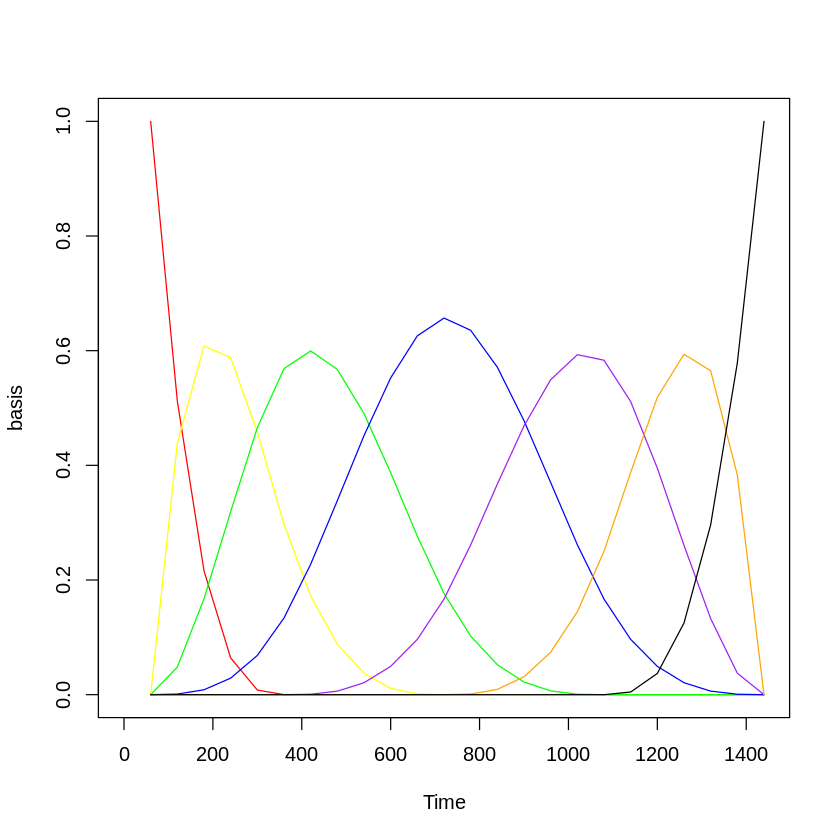

In [ ]:
library(splines)

B <- bs(unique(Sleep_All$minute),
        knots=knot_list,
        degree=knot_degree,
        intercept=TRUE)

str(B)
head(B, 10)

cols <- c("red", "yellow", "green", "blue", "purple", "orange", "black")
plot(NULL, xlim=c(0, 1440), ylim=c(0,1), xlab="Time", ylab="basis")
for(i in 1:(ncol(B))){
 lines(unique(Sleep_All$minute), B[,i], col=cols[i])
}

In [ ]:
B1 <- B[,1]
B2 <- B[,2]
B3 <- B[,3]
B4 <- B[,4]
B5 <- B[,5]
B6 <- B[,6]
B7 <- B[,7]

NREMS_model_1 <- quap(
  alist(
    NREMS ~ dnorm(mu, sigma),
      mu <- #a[treatment] +
            b_time[treatment]*time + # provides a time-dependent intercept
            #B1*w1[treatment] +
            #B2*w2[treatment] +
            B3*w3[treatment] +
            B4*w4[treatment] +
            B5*w5[treatment] +
            #B6*w6[treatment] +
            B7*w7[treatment],
        #a[treatment] <- b_time[treatment]*time,
          b_time[treatment] ~ dnorm(30, 10),
        #w1[treatment] ~ dnorm(30, 10),
        #w2[treatment] ~ dnorm(30, 10),
        w3[treatment] ~ dnorm(30, 10),
        w4[treatment] ~ dnorm(30, 10),
        w5[treatment] ~ dnorm(30, 10),
        #w6[treatment] ~ dnorm(30, 10),
        w7[treatment] ~ dnorm(30, 10),
        #w8[treatment] ~ dnorm(30, 10),
        #w9[treatment] ~ dnorm(30, 10),
      sigma ~ dexp(1)
  ), data=list(NREMS=Sleep_All$NREMS,
               treatment=as.integer(Sleep_All$treatment)+1,
               time=Sleep_All$Block,
               B3=B3, B4=B4, B5=B5, B7=B7),
     start=list(w3=1, w4=1, w5=1, w7=1)
)

precis(NREMS_model_1, depth=2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
w3[1],-8.263834,8.0795893,-21.176579,4.6489098
w3[2],-5.038444,8.0521794,-17.907382,7.8304940
w4[1],-13.049113,7.6177353,-25.223725,-0.8745005
w4[2],-10.430557,7.6078297,-22.589339,1.7282239
w5[1],-7.940792,8.1354385,-20.942794,5.0612097
w5[2],-5.554880,8.1118796,-18.519230,7.4094706
w7[1],3.639473,7.9562818,-9.076202,16.3551482
w7[2],4.935247,7.9402710,-7.754839,17.6253339
b_time[1],20.382088,0.2659369,19.957070,20.8071067


In [ ]:
post <- extract.samples(NREMS_model_1)
str(post)

List of 6
 $ sigma : num [1:10000] 44.6 43.7 43.7 42.9 41.4 ...
 $ w3    : num [1:10000, 1:2] 3.277 -13.87 -22.222 0.192 -11.828 ...
 $ w4    : num [1:10000, 1:2] -19.94 -7.69 -23.13 -10.57 -8.52 ...
 $ w5    : num [1:10000, 1:2] 6.55 -4.51 -13.96 -12.71 2.21 ...
 $ w7    : num [1:10000, 1:2] 4.7 2.82 -1.63 2.38 -5.19 ...
 $ b_time: num [1:10000, 1:2] 20.3 20.3 20.6 20.2 20.4 ...
 - attr(*, "source")= chr "quap posterior: 10000 samples from NREMS_model_1"


In [ ]:
post$a_ctrl <- matrix(data=NA,
                      nrow=nrow(post$b_time),
                      ncol=m_NREMS)
post$a_trt <- matrix(data=NA,
                     nrow=nrow(post$b_time),
                     ncol=m_NREMS)
for(block in 1:m_NREMS){
  post$a_ctrl[,block] <- block * post$b_time[,1]
  post$a_trt[,block] <- block * post$b_time[,2]
}

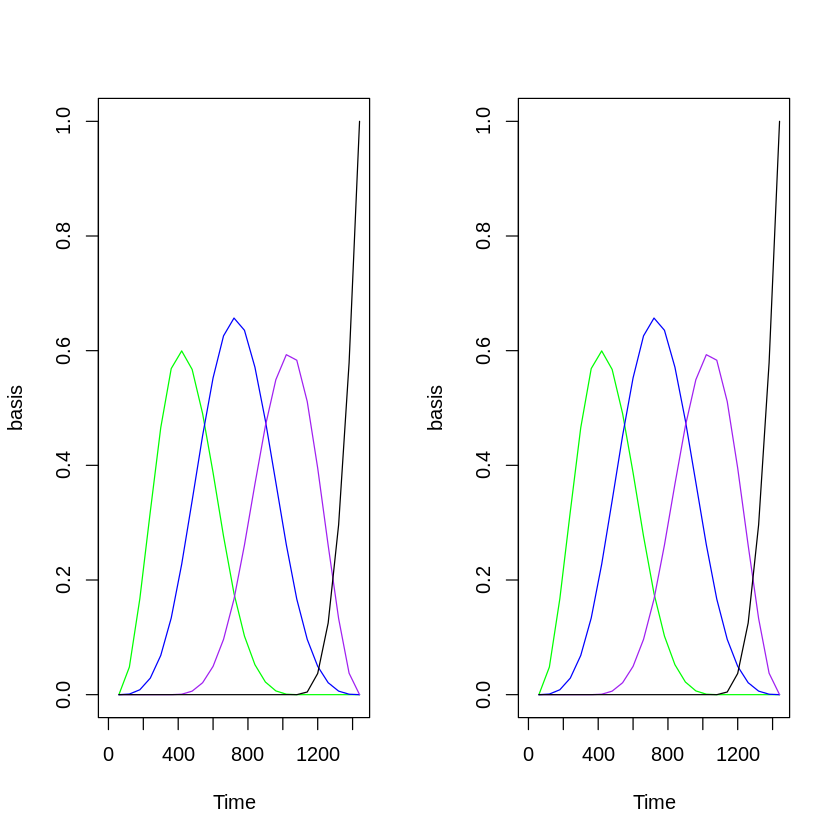

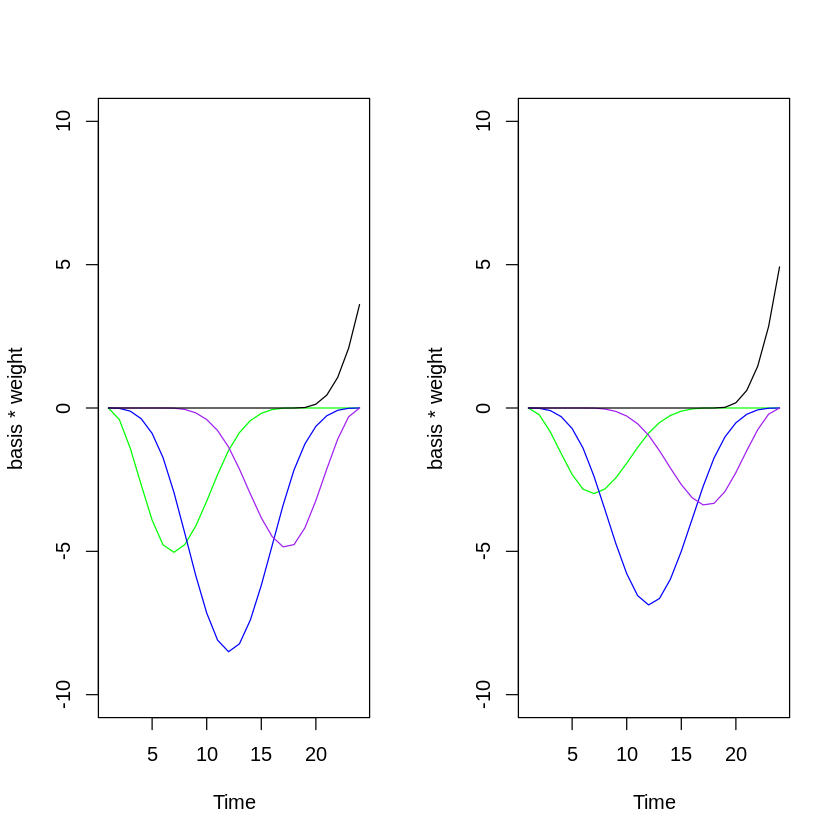

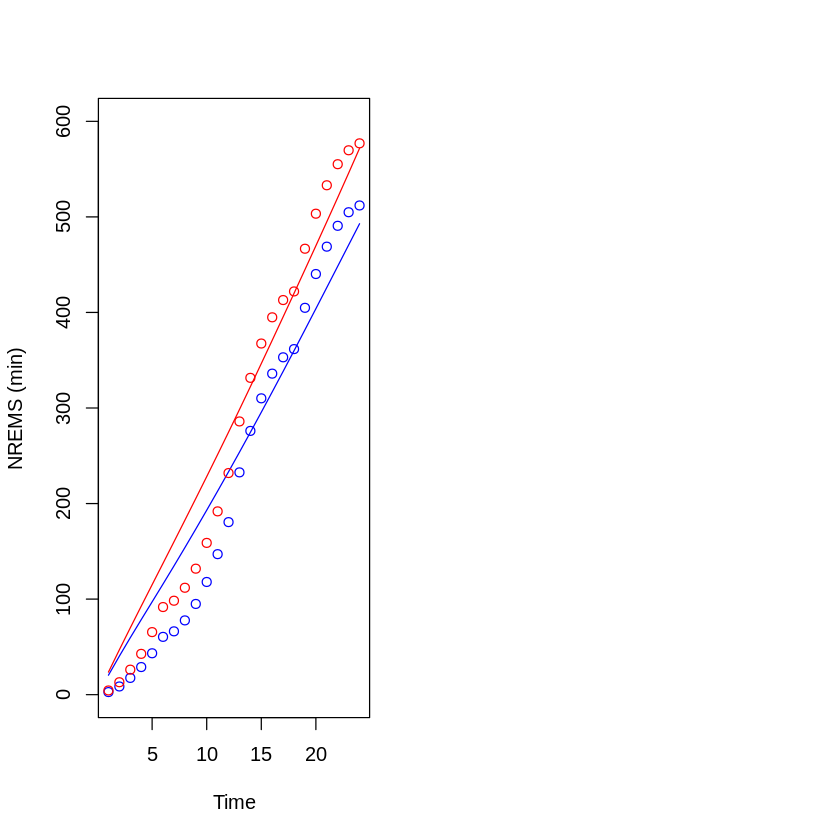

In [ ]:
cols <- c("red", "yellow", "green", "blue", "purple", "orange", "black")
Bs <- c(3,4,5,7)

par(mfrow=c(1,2))
plot(NULL, xlim=c(0, 1440), ylim=c(0,1), xlab="Time", ylab="basis")
  for(i in Bs){
    lines(unique(Sleep_All$minute), B[,i], col=cols[i])
  }
plot(NULL, xlim=c(0, 1440), ylim=c(0,1), xlab="Time", ylab="basis")
  for(i in Bs){
    lines(unique(Sleep_All$minute), B[,i], col=cols[i])
  }

par(mfrow=c(1,2))
plot(B3*mean(post$w3[,1]), type="l", col=cols[3], ylim=c(-10,10), xlab="Time", ylab="basis * weight")
  lines(B4*mean(post$w4[,1]), col=cols[4])
  lines(B5*mean(post$w5[,1]), col=cols[5])
  lines(B7*mean(post$w7[,1]), col=cols[7])
plot(B3*mean(post$w3[,2]), type="l", col=cols[3], ylim=c(-10,10), xlab="Time", ylab="basis * weight")
  lines(B4*mean(post$w4[,2]), col=cols[4])
  lines(B5*mean(post$w5[,2]), col=cols[5])
  lines(B7*mean(post$w7[,2]), col=cols[7])

plot(colMeans(post$a_ctrl) +
     B3*mean(post$w3[,1]) +
     B4*mean(post$w4[,1]) +
     B5*mean(post$w5[,1]) +
     B7*mean(post$w7[,1]),
     col="blue", type="l", ylim=c(0, 600), xlab="Time", ylab="NREMS (min)")
lines(colMeans(post$a_trt) +
      B3*mean(post$w3[,2]) +
      B4*mean(post$w4[,2]) +
      B5*mean(post$w5[,2]) +
      B7*mean(post$w7[,2]), col="red")
points(colMeans(NREMS_A_cuml), col="blue")
points(colMeans(NREMS_B_cuml), col="red")


These splines don't seem to fit the data very well.  Let's try something different.

# Model 2

Recall that splines provide a set of *basis* values, and the model determines how to grow/shrink those value to best fit the data.  The problem with our last model was that these basis values were not great.  What if we used a similar method but used different basis values?

Recall that sleep occurs in cycles.  We can represent cycles over time with sine (or cosine) waves.  So let's use sine waves of different frequencies as our basis this time.

In [ ]:
sine24 <- sin(2*pi/24*Sleep_All$Block)
sine12 <- sin(2*pi/12*Sleep_All$Block)
sine6 <- sin(2*pi/6*Sleep_All$Block)
sine3 <- sin(2*pi/3*Sleep_All$Block)
sine1_5 <- sin(2*pi/1.5*Sleep_All$Block)
sine0_75 <- sin(2*pi/0.75*Sleep_All$Block)

In [ ]:
NREMS_model_2 <- quap(
  alist(
    NREMS ~ dnorm(mu, sigma),
      mu <- b_time[treatment]*time +
            b24[treatment]*sine24 +
            b12[treatment]*sine12 +
            b6[treatment]*sine6 +
            b3[treatment]*sine3 +
            b1_5[treatment]*sine1_5 +
            b0_75[treatment]*sine0_5,
              b_time[treatment] ~ dnorm(30, 10),
              b24[treatment] ~ dnorm(0, 20),
              b12[treatment] ~ dnorm(0, 20),
              b6[treatment] ~ dnorm(0, 20),
              b3[treatment] ~ dnorm(0, 20),
              b1_5[treatment] ~ dnorm(0, 20),
              b0_75[treatment] ~ dnorm(0, 20),
      sigma ~ dexp(1)
  ), data=list(NREMS=Sleep_All$NREMS,
               treatment=as.integer(Sleep_All$treatment)+1,
               time=Sleep_All$Block,
               TotalPreviousSleep=Sleep_All$TotalPreviousSleep,
               sine24=sine24, sine12=sine12, sine6=sine6, sine3=sine3, sine1_5=sine1_5, sine0_5=sine0_75)
)

precis(NREMS_model_2, depth=2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
b_time[1],18.8515301,0.1305291,18.642919,19.0601407
b_time[2],22.2857888,0.1305277,22.077180,22.4943973
b24[1],-60.1788486,2.5646830,-64.277707,-56.0799898
b24[2],-56.4983013,2.5645827,-60.597000,-52.3996029
b12[1],-4.1560795,2.4184580,-8.021242,-0.2909166
b12[2],-2.1145530,2.4184501,-5.979703,1.7505974
b6[1],-4.2884227,2.3807386,-8.093303,-0.4835426
b6[2],-2.9550490,2.3807347,-6.759923,0.8498249
b3[1],-0.4808565,16.3487635,-26.609338,25.6476252


In [ ]:
post <- extract.samples(NREMS_model_2)
str(post)

List of 8
 $ sigma : num [1:10000] 26 26.8 25.7 26.8 25.6 ...
 $ b_time: num [1:10000, 1:2] 18.9 18.7 18.7 19 18.9 ...
 $ b24   : num [1:10000, 1:2] -57.3 -57.5 -64.9 -62.2 -63.8 ...
 $ b12   : num [1:10000, 1:2] -4.56 -5.24 -3.46 -1.18 -6.68 ...
 $ b6    : num [1:10000, 1:2] -8.14 -4.32 -7.22 -5.76 -5.38 ...
 $ b3    : num [1:10000, 1:2] 25.5 -5.09 5.28 6.82 -25.32 ...
 $ b1_5  : num [1:10000, 1:2] 46.2 -13.1 16.6 -20.9 -19.7 ...
 $ b0_75 : num [1:10000, 1:2] 20.56 -8.84 8.06 -26.93 4.8 ...
 - attr(*, "source")= chr "quap posterior: 10000 samples from NREMS_model_2"


In [ ]:
time_seq <- 1:24
sine24_seq <- sin(2*pi/24*time_seq)
sine12_seq <- sin(2*pi/12*time_seq)
sine6_seq <- sin(2*pi/6*time_seq)
sine3_seq <- sin(2*pi/3*time_seq)
sine1.5_seq <- sin(2*pi/1.5*time_seq)
sine0.75_seq <- sin(2*pi/0.75*time_seq)

In [ ]:
post$a_ctrl <- matrix(data=NA,
                      nrow=nrow(post$b_time),
                      ncol=m_NREMS)
post$a_trt <- matrix(data=NA,
                     nrow=nrow(post$b_time),
                     ncol=m_NREMS)
for(block in 1:m_NREMS){
  post$a_ctrl[,block] <- block * post$b_time[,1]
  post$a_trt[,block] <- block * post$b_time[,2]
}

In [ ]:
post$NREMSA24 <- post$b24[,1] %*% t(sine24_seq)
post$NREMSA12 <- post$b12[,1] %*% t(sine12_seq)
post$NREMSA6 <- post$b6[,1] %*% t(sine6_seq)
post$NREMSA3 <- post$b3[,1] %*% t(sine3_seq)
post$NREMSA1.5 <- post$b1_5[,1] %*% t(sine1.5_seq)
post$NREMSA0.75 <- post$b0_75[,1] %*% t(sine0.75_seq)

post$NREMSB24 <- post$b24[,2] %*% t(sine24_seq)
post$NREMSB12 <- post$b12[,2] %*% t(sine12_seq)
post$NREMSB6 <- post$b6[,2] %*% t(sine6_seq)
post$NREMSB3 <- post$b3[,2] %*% t(sine3_seq)
post$NREMSB1.5 <- post$b1_5[,2] %*% t(sine1.5_seq)
post$NREMSB0.75 <- post$b0_75[,2] %*% t(sine0.75_seq)

In [ ]:
post$NREMS_A <- with(post,
                      a_ctrl +
                      NREMSA24 +
                      NREMSA12 +
                      NREMSA6 +
                      NREMSA3 +
                      NREMSA1.5 +
                      NREMSA0.75)
post$NREMS_A_mean <- colMeans(post$NREMS_A)
post$NREMS_A_CrI <- apply(post$NREMS_A, 2, HPDI, 0.95)

post$NREMS_B <- with(post,
                      a_trt +
                      NREMSB24 +
                      NREMSB12 +
                      NREMSB6 +
                      NREMSB3 +
                      NREMSB1.5 +
                      NREMSB0.75)
post$NREMS_B_mean <- colMeans(post$NREMS_B)
post$NREMS_B_CrI <- apply(post$NREMS_B, 2, HPDI, 0.95)

str(post)

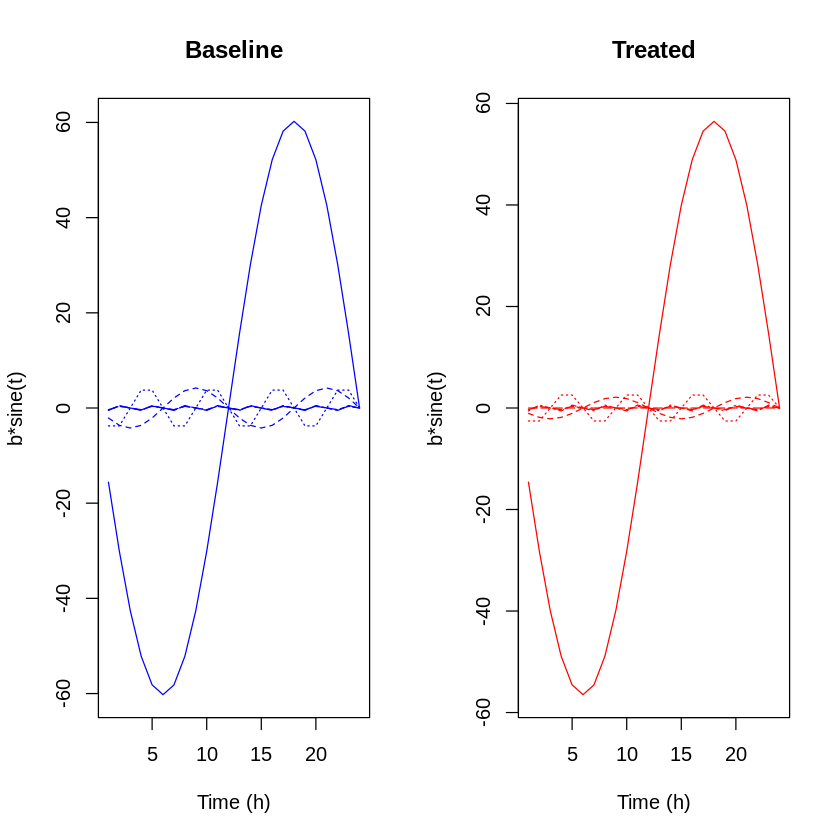

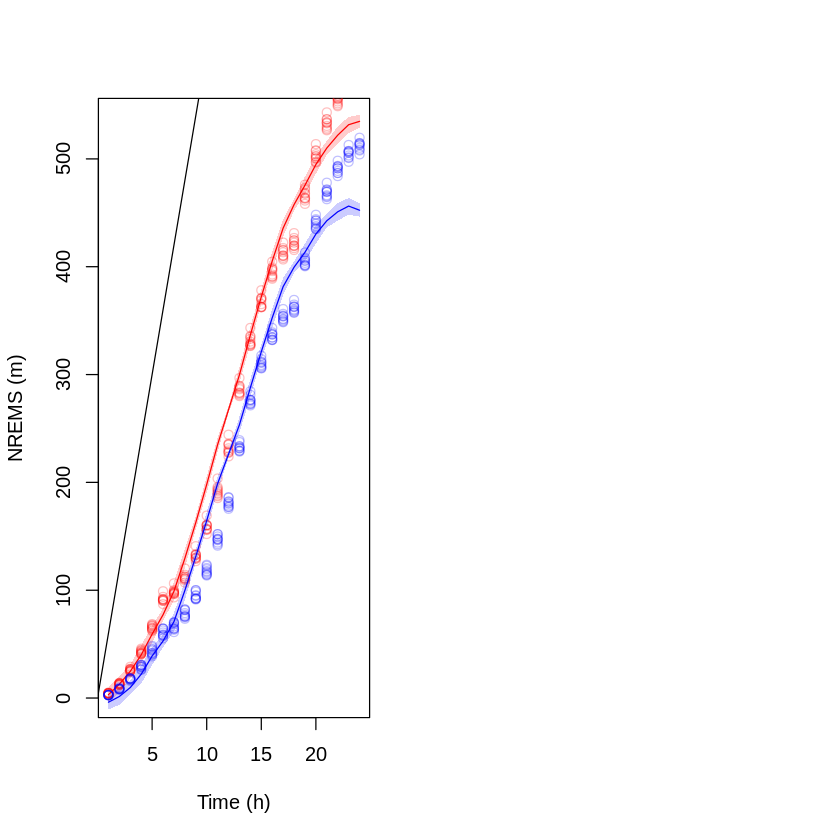

In [ ]:
par(mfrow=c(1,2))
plot(mean(post$b24[,1])*sine24_seq, type="l", xlab="Time (h)", ylab="b*sine(t)", main = "Baseline", col="blue")
lines(mean(post$b12[,1])*sine12_seq, lty=2, col="blue")
lines(mean(post$b6[,1])*sine6_seq, lty=3, col="blue")
lines(mean(post$b3[,1])*sine3_seq, lty=4, col="blue")
lines(mean(post$b1_5[,1])*sine1.5_seq, lty=5, col="blue")
lines(mean(post$b0_75[,1])*sine0.75_seq, lty=5, col="blue")

plot(mean(post$b24[,2])*sine24_seq, type="l", xlab="Time (h)", ylab="b*sine(t)", main = "Treated", col="red")
lines(mean(post$b12[,2])*sine12_seq, lty=2, col="red")
lines(mean(post$b6[,2])*sine6_seq, lty=3, col="red")
lines(mean(post$b3[,2])*sine3_seq, lty=4, col="red")
lines(mean(post$b1_5[,2])*sine1.5_seq, lty=5, col="red")
lines(mean(post$b0_75[,2])*sine0.75_seq, lty=5, col="red")


plot(colMeans(post$NREMS_B), type="l", col="red", xlab="Time (h)", ylab="NREMS (m)")
  shade(post$NREMS_B_CrI, time_seq, col=col.alpha("red", 0.2))
  points(Sleep_All[Sleep_All$treatment==TRUE, "NREMS"] ~ Sleep_All[Sleep_All$treatment==TRUE, "Block"], col=col.alpha("red", 0.25))
lines(colMeans(post$NREMS_A), col="blue")
  shade(post$NREMS_A_CrI, time_seq, col=col.alpha("blue", 0.2))
  points(Sleep_All[Sleep_All$treatment==FALSE, "NREMS"] ~ Sleep_All[Sleep_All$treatment==FALSE, "Block"], col=col.alpha("blue", 0.25))
abline(a=0, b=1440/24)

In [ ]:
t1 <- 2
t2 <- 7

mean(rowSums(with(post,
             NREMS_B[,t1:t2] - NREMS_A[, t1:t2])))

sd(rowSums(with(post,
             NREMS_B[,t1:t2] - NREMS_A[, t1:t2])))

[1] 117.2007

[1] 23.49299

(If you're reading this, know there is more to come here.  I am adding to this in conjuction with another project: [video solutions](https://youtube.com/playlist?list=PL4OalocKlC1R5dZCaD9AHP96Uwkl0Xv0R&si=lQ8bXiuT_iL-XbZC) to the Practice problems from the text book "Statistical Rethinking".  As relevant concepts arise there, I will incorporate them here.)